# vaex をインストール

In [1]:
%%time
!pip install vaex PyQt5 vaex-ui

CPU times: user 76 ms, sys: 16 ms, total: 92 ms
Wall time: 2.61 s


# Google Cloud PlatformのStorageを Compute Engine のVMインスタンスにマウントする

Google Cloud Storage のバケット kunsen_taxi を　~/taxi にマウントする

In [0]:
%%time
%cd ~
%mkdir taxi
!gcsfuse kunsen_taxi taxi
%ls -l taxi
%ls -l 

/home/dr_ml_outlook_jp
mkdir: cannot create directory ‘taxi’: File exists
Using mount point: /home/dr_ml_outlook_jp/taxi
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
total 158841877
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp 114931001050 Mar 28 09:24 yellow_taxi_2009_2015_f32.hdf5
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp  31401328834 Mar 23 21:30 yellow_taxi_2009_2015_f32.zip
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp  12857976625 Mar 28 15:37 yellow_taxi_2015_f32s.hdf5
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp   3463774316 Mar 23 21:30 yellow_taxi_2015_f32s.zip
total 112237196
drwxr-xr-x 1 dr_ml_outlook_jp dr_ml_outlook_jp            0 Mar 29 00:27 taxi/
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp 114930876416 Mar 29 00:12 yellow_taxi_2009_2015_f32.hdf5
CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 884 ms


taxi/yellow_taxi_2009_2015_f32.hdf5を ~ にコピーする

In [0]:
%%time
%cd ~
#%cp "taxi/yellow_taxi_2009_2015_f32.hdf5" .
!gsutil cp "gs://kunsen_taxi/yellow_taxi_2009_2015_f32.hdf5" ~
%ls -l 

/home/dr_ml_outlook_jp
Copying gs://kunsen_taxi/yellow_taxi_2009_2015_f32.hdf5...
|
Operation completed over 1 objects/107.0 GiB.                                    
total 112237324
drwxr-xr-x 1 dr_ml_outlook_jp dr_ml_outlook_jp            0 Mar 29 00:27 taxi/
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp 114931001050 Mar 29 01:48 yellow_taxi_2009_2015_f32.hdf5
CPU times: user 1min 31s, sys: 18.5 s, total: 1min 50s
Wall time: 1h 13min 48s


ディスク容量とメモリ量を確認する

In [2]:
!df
!free
!ls -l

Filesystem     1K-blocks      Used Available Use% Mounted on
udev             7691180         0   7691180   0% /dev
tmpfs            1540472     18744   1521728   2% /run
/dev/sda1      206356436 137119480  60727660  70% /
tmpfs            7702348         0   7702348   0% /dev/shm
tmpfs               5120         0      5120   0% /run/lock
tmpfs            7702348         0   7702348   0% /sys/fs/cgroup
tmpfs            1540468         0   1540468   0% /run/user/872222053
              total        used        free      shared  buff/cache   available
Mem:       15404700      409344    14535340       18744      460016    14710840
Swap:             0           0           0
total 112237328
drwxr-xr-x 2 dr_ml_outlook_jp dr_ml_outlook_jp         4096 Mar 28 23:16 taxi
-rw-r--r-- 1 dr_ml_outlook_jp dr_ml_outlook_jp 114931001050 Mar 29 01:48 yellow_taxi_2009_2015_f32.hdf5


# Exploratory data analysis: N. Y. CityCabs data: 2009-2015

In [3]:
%%time
import vaex
from vaex.ui.colormaps import cm_plusmin

import numpy as np
import pylab as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")

CPU times: user 1.68 s, sys: 320 ms, total: 2 s
Wall time: 4.91 s


### Adjusting `matplotlib` parameters

In [4]:
%%time
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 78.7 µs


### Obtaining the data

The original data is courtesy of the New York City Taxi and Limousine Commision, and can be downloaded from [this website](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

The data was then converted to the memory-mappable HDF5 file format. For an example on how to do this, you may want to look at [this notebook](https://nbviewer.jupyter.org/github/vaexio/vaex-examples/blob/master/medium-airline-data-eda/airline-original-data-conversion.ipynb).

### Read in the data

- Can "read" the memmory mapped file that we have on disk in no time.
- `Vaex` can also read data stored on S3. The data is streamed on need-to-have basis and is locally cached.

In [0]:
# # Read in the data from S3
# df = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')

In [6]:
%%time
# Read in the data from disk
df = vaex.open('yellow_taxi_2009_2015_f32.hdf5')

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 579 ms


In [7]:
%%time
# A view into the data
df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
<i style='opacity: 0.6'>0</i>,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
<i style='opacity: 0.6'>1</i>,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
<i style='opacity: 0.6'>2</i>,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
<i style='opacity: 0.6'>3</i>,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
<i style='opacity: 0.6'>4</i>,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"<i style='opacity: 0.6'>1,173,057,922</i>",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"<i style='opacity: 0.6'>1,173,057,923</i>",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"<i style='opacity: 0.6'>1,173,057,924</i>",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"<i style='opacity: 0.6'>1,173,057,925</i>",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


### Quick insights into this dataset

This is done with a single pass over the data

In [8]:
%%time
# Get a high level overview of the DataFrame
df.describe()

CPU times: user 8min 51s, sys: 1min 1s, total: 9min 53s
Wall time: 41min 53s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
dtype,str,datetime64[ns],datetime64[ns],int64,str,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
count,1173057927,1173057927,1173057927,1173057927,1173057927,1173057927,1173057927,1173057926,1002161871,638914438,1173043432,1173050240,1173057925,1173057925,1032017356,1173057925,1173057925,1173057925
NA,0,0,0,0,0,0,0,1,170896056,534143489,14495,7687,2,2,141040571,2,2,2
mean,--,1970-01-01T00:00:01.953533625,1970-01-01T00:00:14.506598422,1.6844313554517245,--,5.390923661260678,-72.532248447029,39.93453139351851,1.035820754150404,0.017168377090266976,-72.53741806425039,39.93694872311005,11.21730815580395,0.30363852323796525,0.4963069205116383,1.1294571893017407,0.18678067517757657,13.314765814202369
std,--,6.22239e+16,6.22266e+16,1.33032,--,7756.52,12.7505,9.51675,0.441996,0.129899,12.6768,9.50487,633.505,0.395407,0.0683994,132.842,886.718,1098.43
min,--,2009-01-01T00:00:27.365015552,1899-12-31T23:59:43.370698752,0,--,-4.08401e+07,-3509.02,-3579.14,0,0,-3579.14,-3579.14,-2.14748e+07,-79,-3,-1.67772e+06,-2.14748e+07,-2.14748e+07
max,--,2016-01-01T00:00:49.632313344,2253-08-23T08:00:13.061652480,255,--,1.98623e+08,3570.22,3577.14,252,2,3460.43,3577.14,825999,999.99,1311.22,3.95059e+06,5510.07,3.95061e+06


### Getting read of outliers and errouneous data

In this section we will use the output of describe to get rid of outliers, and other erroneous data.
Let's start with the City of New York itself. 

Let's visualise the pickup locations.

In [9]:
%%time
'''
# Interactively visualise the pickup locations of all taxi trips in our dataset.
df.plot_widget(df.pickup_longitude, 
               df.pickup_latitude, 
               shape=512, 
               limits='minmax',
               f='log1p', 
               colormap='plasma')
'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


"\n# Interactively visualise the pickup locations of all taxi trips in our dataset.\ndf.plot_widget(df.pickup_longitude, \n               df.pickup_latitude, \n               shape=512, \n               limits='minmax',\n               f='log1p', \n               colormap='plasma')\n"

With Vaex we can interactively explore such heamaps as the one above, even when the data contains over 1 billion samples. This way we can choose the spatial extent over which the taxi company operates in New York City. In fact, it is mostly Manhattan.

In [10]:
%%time
# Define the boundaries by interactively choosing the area of interest!
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_filtered = df[(df.pickup_longitude > long_min)  & (df.pickup_longitude < long_max) & \
                 (df.pickup_latitude > lat_min)    & (df.pickup_latitude < lat_max) & \
                 (df.dropoff_longitude > long_min) & (df.dropoff_longitude < long_max) & \
                 (df.dropoff_latitude > lat_min)   & (df.dropoff_latitude < lat_max)]

CPU times: user 340 ms, sys: 1.6 s, total: 1.94 s
Wall time: 1.95 s


From the output of the `describe` method we see that the maximum number of passengers is 255! 
Let's make a bar plot showing the common number of passengers in a taxi trip.

[######----------------------------------] 15.73% estimated time:   980.46s =  16.3m =  0.3h 

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


[########################################] 100.00% elapsed time  :  1156.84s =  19.3m =  0.3h
 

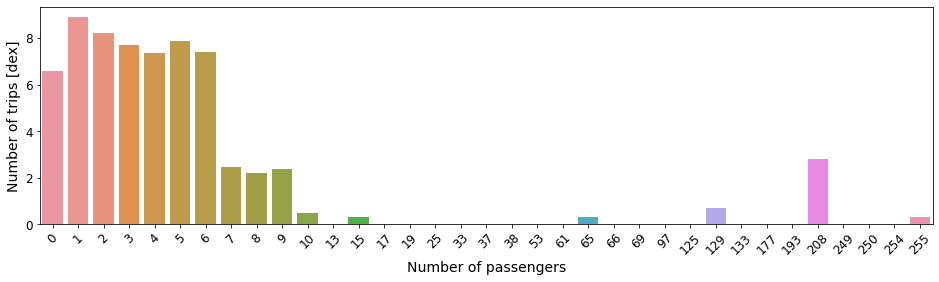

CPU times: user 25.5 s, sys: 11.2 s, total: 36.7 s
Wall time: 19min 17s


In [11]:
%%time
# Get number of unique trips with certain number of passengers
num_passengers = df_filtered.passenger_count.value_counts(progress=True)

# Plot the result
plt.figure(figsize=(16, 4))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

First impressions: Typical number of passengers in a ride between 1-6. Very large number of taxi trips with 0 passengeres. Are these deliveries maybe, or were passengers not recorded. There are few hundreds of taxi trips with 7-9 passengers, and beyond that the numbers look erroneous. 

In this analysis we will focus only on the trips with typical number of passengers, that is between 1 and 6. So let's add that do the filter.

In [12]:
%%time
# Filterd based on the number of passengers
df_filtered = df_filtered[(df_filtered.passenger_count>0) & (df_filtered.passenger_count<7)]

CPU times: user 168 ms, sys: 572 ms, total: 740 ms
Wall time: 738 ms


Next up, we turn to the distance column. Here we see that the minimum value is negative, i.e. for sure something has gone wrong, and the maximum values is.. well very large! In fact, to put this in perspective:

In [13]:
%%time
# What is the largest distance?
max_trip_distance = df_filtered.trip_distance.max().astype('int')

print(f'The largest distance in the data is {max_trip_distance} miles!')

print(f'This is {max_trip_distance/238_900:.1f} times larger than the distance between the Earth and the Moon!')

The largest distance in the data is 198623008 miles!
This is 831.4 times larger than the distance between the Earth and the Moon!
CPU times: user 21.2 s, sys: 4.08 s, total: 25.3 s
Wall time: 6min 49s


Let's plot the distribution of distances, but in a more sensible range, relative to the scale of the part of New York City we selected above.

[########################################] 100.00% elapsed time  :     3.54s =  0.1m =  0.0h
 

/opt/conda/lib/python3.7/site-packages/vaex/viz/mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


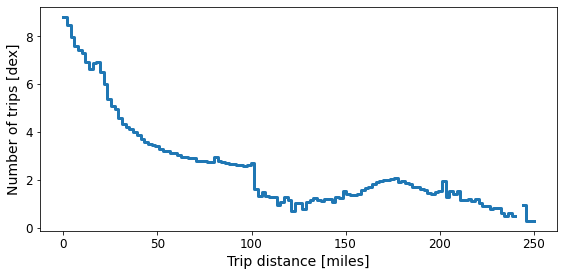

CPU times: user 14.7 s, sys: 68 ms, total: 14.8 s
Wall time: 3.89 s


In [14]:
%%time
# Plot the distribution of distances.
plt.figure(figsize=(8, 4))
df_filtered.plot1d('trip_distance', limits=[0, 250], f='log10', shape=128, lw=3, progress=True)
plt.xlabel('Trip distance [miles]')
plt.ylabel('Number of trips [dex]')
plt.show()

So we observe that at ~100 miles, the number of taxi trips drops considerably, and becomes more sporadic. Thus we decide to only consider taxi trip that in total are up to 100 miles.

In [15]:
%%time
# Select taxi trips have travelled maximum 100 miles (but also with non-zero distance).
df_filtered = df_filtered[(df_filtered.trip_distance > 0) & (df_filtered.trip_distance < 100)]

CPU times: user 184 ms, sys: 600 ms, total: 784 ms
Wall time: 785 ms


In the next step of our data cleaning process, let's look at the distributions of trip times and speeds, and make sure they are sensible. These quantities are not readily available in the dataset, but are trivial to compute. We will do this in a rather standard way, but here is the kick: these additional columns do not cost any memory what so ever. This is what we call _virtual columns_.

In [16]:
%%time
# Time in transit (minutes)
df_filtered['trip_duration_min'] = (df_filtered.dropoff_datetime - df_filtered.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

# Speed (miles per hour)
df_filtered['trip_speed_mph'] = df_filtered.trip_distance / \
                                ((df_filtered.dropoff_datetime - df_filtered.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30 ms


[########################################] 100.00% elapsed time  :   759.87s =  12.7m =  0.2h
 

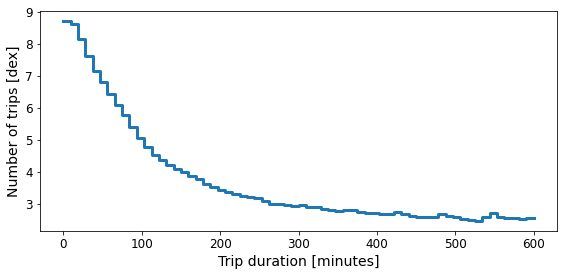

CPU times: user 32.4 s, sys: 20.5 s, total: 52.8 s
Wall time: 12min 42s


In [17]:
%%time
# Plot the distribution of trip durtaions
plt.figure(figsize=(8, 4))
df_filtered.plot1d('trip_duration_min', limits=[0, 600], f='log10', shape=64, lw=3, progress=True)
plt.xlabel('Trip duration [minutes]')
plt.ylabel('Number of trips [dex]')
plt.show()

We see that the majority of taxi trips, 95% to be exact last less than 30 minutes. From the above plot, we see the distribution falls of, and almost becomes flat after 200 minutes. Can you imagine, spending over 3 hours in a taxi in New York City! Perhaps it happens.. 

So let's be..open minded for now, and consider all trips that last less than 3 hours in total.

In [18]:
%%time
# Filter taxi trips that have unreasonably long dirations
df_filtered = df_filtered[(df_filtered.trip_duration_min > 0) & (df_filtered.trip_duration_min < 180)]

CPU times: user 180 ms, sys: 512 ms, total: 692 ms
Wall time: 691 ms


Now let's look at the mean speed of a trip. Let us first look a the extremes:

In [19]:
%%time
# Minimum and maximum average speed of a taxi trip
print('Minimal mean speed: %.3f miles/hour.' % (df_filtered.trip_speed_mph.min()))
print('maximal mean speed: %.3f miles/hour.' % (df_filtered.trip_speed_mph.max()))

Minimal mean speed: 0.003 miles/hour.
maximal mean speed: 234359.995 miles/hour.
CPU times: user 1min 22s, sys: 58.8 s, total: 2min 21s
Wall time: 34min


From the extremes of this column we notice that we have some serious outliers. On the lower end of the spectrum, the slowest speeds are considerably slower than walking sleeds. On the high end of the spectrum, those cars are flying so fast, they can be used as spaceships! 

Let us plot the distribution of mean speeds, for a more sensible, or at least physically viable range.

[########################################] 100.00% elapsed time  :   597.27s =  10.0m =  0.2h
 

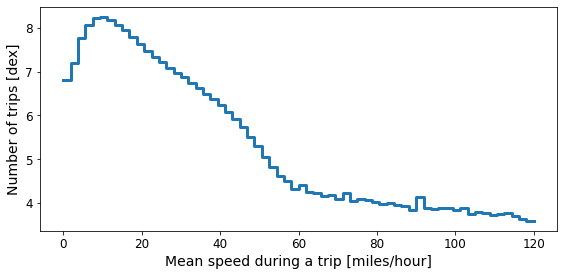

CPU times: user 29.9 s, sys: 22.5 s, total: 52.4 s
Wall time: 9min 58s


In [20]:
%%time
# Plot the distribution of trip durtaions
plt.figure(figsize=(8, 4))
df_filtered.plot1d('trip_speed_mph', limits=[0, 120], f='log10', shape=64, lw=3, progress=True)
plt.xlabel('Mean speed during a trip [miles/hour]')
plt.ylabel('Number of trips [dex]')
plt.show()

Based on this plot we can make a sensible choce of a typical trip speed: somewhere in the range of 1-60 miles per hour.

In [21]:
%%time
# Filter out errouneous average trip speeds.
df_filtered = df_filtered[(df_filtered.trip_speed_mph > 1) & (df_filtered.trip_speed_mph < 60)]

CPU times: user 152 ms, sys: 584 ms, total: 736 ms
Wall time: 737 ms


Finally, let's look at the cost of the taxi trips. From the output of the `describe()` function, we can see that there are some crazy outliers in the *fare_amount*, *total_amount*, and *tip_amount*. For starters, no value in these columns should be negative. Also their upper limits are ridiculously high. Let's look at their distributions, but in a more sensible range.

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


[########################################] 100.00% elapsed time  :   196.00s =  3.3m =  0.1h
 

/opt/conda/lib/python3.7/site-packages/vaex/viz/mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


[########################################] 100.00% elapsed time  :   195.28s =  3.3m =  0.1h
[########################################] 100.00% elapsed time  :   196.11s =  3.3m =  0.1h
 

/opt/conda/lib/python3.7/site-packages/vaex/viz/mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


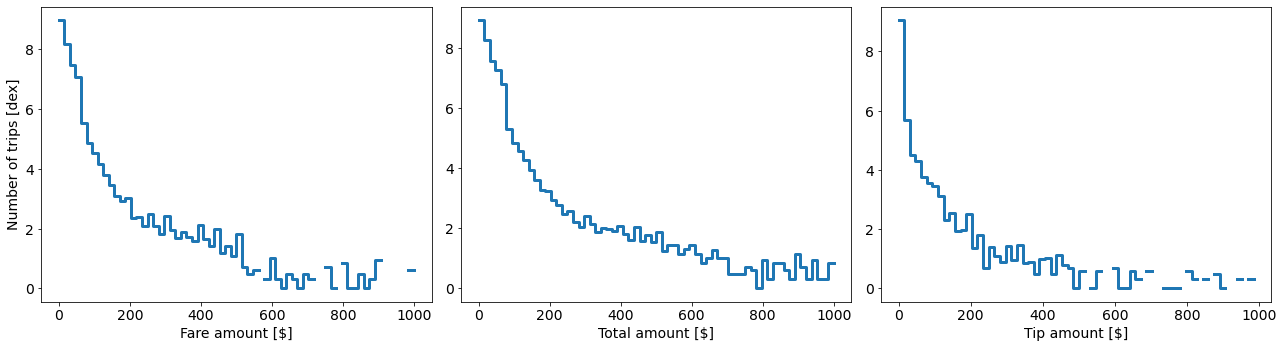

CPU times: user 1min 9s, sys: 21.9 s, total: 1min 31s
Wall time: 24min 33s


In [22]:
%%time
plt.figure(figsize=(18, 5))

plt.subplot(131)
df_filtered.plot1d('fare_amount', shape=64, lw=3, limits=[0, 1000], f='log10', progress=True)
plt.xlabel('Fare amount [$]')
plt.ylabel('Number of trips [dex]')
plt.tick_params(labelsize=14)

plt.subplot(132)
df_filtered.plot1d('total_amount', shape=64, lw=3, limits=[0, 1000], f='log10', progress=True)
plt.xlabel('Total amount [$]')
plt.ylabel('')
plt.tick_params(labelsize=14)

plt.subplot(133)
df_filtered.plot1d('tip_amount', shape=64, lw=3, limits=[0, 1000], f='log10', progress=True)
plt.xlabel('Tip amount [$]')
plt.ylabel('')
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

We see that in all three cases, these distribution have some very long tail. Perhaps few of these large fares are legit, most are probably or hopefully errouneous data, or maybe some funny business is going on from time to time. In any case, we would like to focus on the regular "vanilla" rides, so we will select all trips that have total and fare amount less than \\$200 (the elbow of the distributions). Same for the tips. Note that the tips are not included in the total amount column.  We also require that the fare and total amount be larger than \\$0. This condition is not imposed on the tips, although none of these can be negative.

In [23]:
%%time
df_filtered = df_filtered[((df_filtered.total_amount > 0) & (df_filtered.total_amount < 200) & 
                           (df_filtered.fare_amount > 0) & (df_filtered.fare_amount < 200) &
                           (df_filtered.tip_amount >= 0) & (df_filtered.tip_amount < 200))]

CPU times: user 164 ms, sys: 556 ms, total: 720 ms
Wall time: 749 ms


Finally, after this initial cleaning of the data is done, let's see how many taxi trips we have left

In [24]:
%%time
N_samples = len(df_filtered)
print(f'Number of trips in the filtered dataset: {N_samples}')

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less
<string>:1: RuntimeWarning: invalid value encountered in greater_equal


Number of trips in the filtered dataset: 1129396332
CPU times: user 13.4 s, sys: 6.3 s, total: 19.7 s
Wall time: 9min 17s


We have over 1.1 billion taxi trips for our upcoming analysis. Let's get to it!

### General Exploratory Data Analysis

Let's assume we are a prospective taxi driver, or even a manager of a taxi company, and are interested in finding out where are, on average, the best hotspots to pick up passengers from, which will lead to large taxi fees.

Naively, we can just plot a map of the pickup locations color-coded by the average fare amount for that big, i.e. part of the town. 

However, as a taxi driver, we have our own expences as well. We need to pay for fuel, or taking a passenger somewhere remote might mean that we will spend a lot of time and fuel just getting back to the city centre, and perhaps it will not be so easy to find a passenger for our trip back. Having that into consideration, we decide to instead color code the map of NYC by the mean of the trip fare divided by the trip distance. This is simple way we can introduce normalization, i.e. taking some of our costs into account.

These two cases are plotted below

In [25]:
%%time
# Define new columns that might prove useful:
df_filtered['tip_percentage'] = df_filtered.tip_amount / df_filtered.total_amount * 100.
df_filtered['fare_over_distance'] = df_filtered.fare_amount / df_filtered.trip_distance

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 174 µs


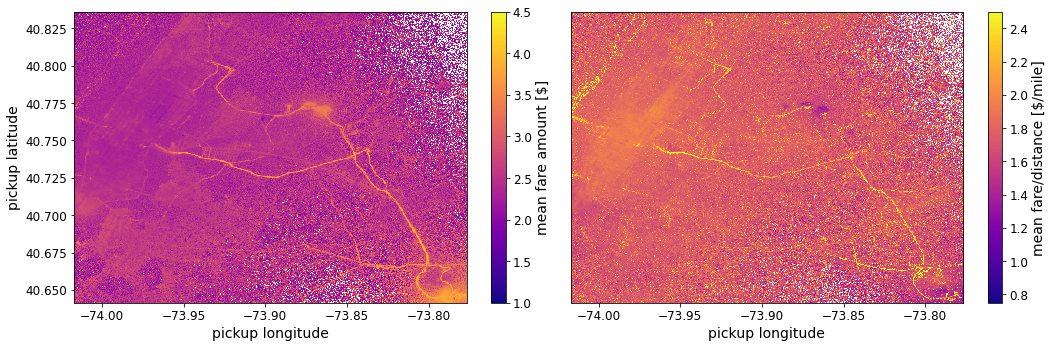

CPU times: user 2min 22s, sys: 34.7 s, total: 2min 56s
Wall time: 20min 40s


In [26]:
%%time
plt.figure(figsize=(15, 5))

plt.subplot(121)
df_filtered.plot('pickup_longitude', 'pickup_latitude', what='mean(fare_amount)',
                 colormap='plasma', f='log1p', shape=512, colorbar=True, 
                 colorbar_label='mean fare amount [$]', vmin=1, vmax=4.5)

plt.xlabel('pickup longitude')
plt.ylabel('pickup latitude')

plt.subplot(122)
df_filtered.plot('pickup_longitude', 'pickup_latitude', what='mean(fare_over_distance)',
                 colormap='plasma', f='log1p', shape=512, colorbar=True, 
                 colorbar_label='mean fare/distance [$/mile]', vmin=0.75, vmax=2.5)

plt.xlabel('pickup longitude')
plt.ylabel('')
plt.gca().axes.get_yaxis().set_visible(False)


plt.tight_layout()
plt.show()

We see that in the 1st case, if we just care about getting the maximum fare for the service provided, it is best to pick up passengers around the NYC airprots, and long the main streets, such as the Van Wyck Expressway, and Long Island Expressway avenues.

However, when we divide by the distance travelled, we get a slightly different picture. The Van Wyck Expressway, and Long Island Expressway avenues are still relevant, but much less prominant, the airports are not as popular. Some other hotspots appear on the other side of the Hudson river, which seem quite profitable locations to pick up passengers from.

##### When do trips happens

Next, we wanna figure out when do most of the taxi usage happens so we can schedule our working hours appropriately.

In [27]:
%%time
# Extract some date/time features
df_filtered['pickup_hour'] = df_filtered.pickup_datetime.dt.hour
df_filtered['pickup_day_of_week'] = df_filtered.pickup_datetime.dt.dayofweek
df_filtered['pickup_month'] = df_filtered.pickup_datetime.dt.month - 1  # to count from zero
df_filtered['pickup_is_weekend'] = (df_filtered.pickup_day_of_week>=5)

# Treat these columns as label/ordinal encoded values
df_filtered.categorize(column='pickup_hour')
df_filtered.categorize(column='pickup_day_of_week')
df_filtered.categorize(column='pickup_month')

# Helper lists for labelling the plots 
label_month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
label_day_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

CPU times: user 6min 36s, sys: 45.1 s, total: 7min 21s
Wall time: 15min 18s


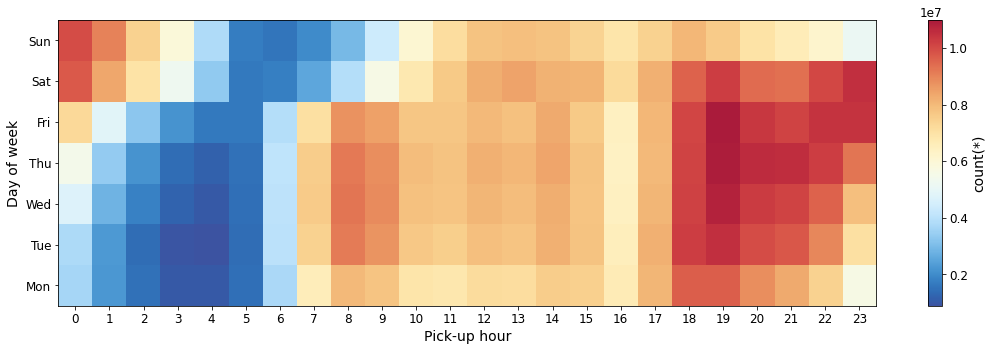

CPU times: user 5min 22s, sys: 764 ms, total: 5min 23s
Wall time: 1min 23s


In [28]:
%%time
# Plot number of taxi trips per hours vs day of week
plt.figure(figsize=(15, 5))
df_filtered.plot('pickup_hour', 'pickup_day_of_week', colorbar=True, colormap=cm_plusmin)
plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()

This makes sense: most of the trips happen in the eveings, specifically Friday night and Saturday night are very popular. Conversly there is little taxi traffic in the early hours of the day. Notice that there is a small peak in the distribution at around 8-9 in the morning on the work days. The same time slot during the weekends seem to see little taxi traffic. Is this the time when people hurry to go to work or work-related events (on the weekends this would not be true)?

Now let's look when the taxi trips take longer (or shorter time).

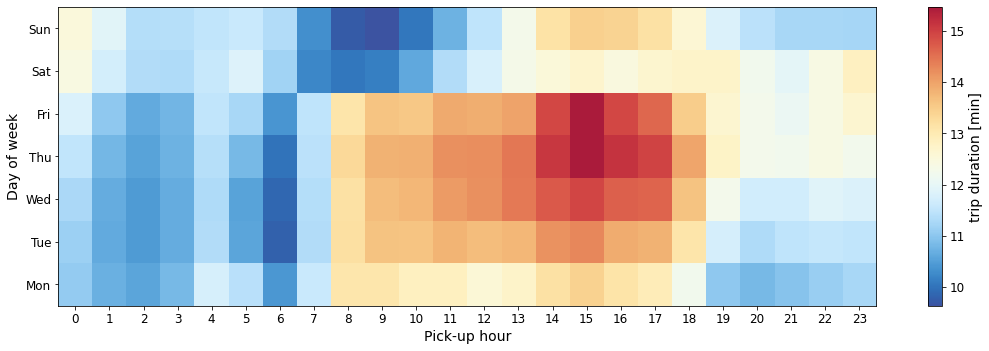

CPU times: user 4min 25s, sys: 8.24 s, total: 4min 33s
Wall time: 5min 47s


In [29]:
%%time
plt.figure(figsize=(15, 5))
df_filtered.plot('pickup_hour', 'pickup_day_of_week', what='mean(trip_duration_min)', 
                 colorbar_label='trip duration [min]', colorbar=True, colormap=cm_plusmin)
plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()

On average the trips take longest time around 14-17 o'clock. The shortest trips happen in the weekends in the mornings 8-10 o'clock, as well as the at ~6 o'clock during the working days.

Let's see how the mean speed varies as a function of time and day of week.

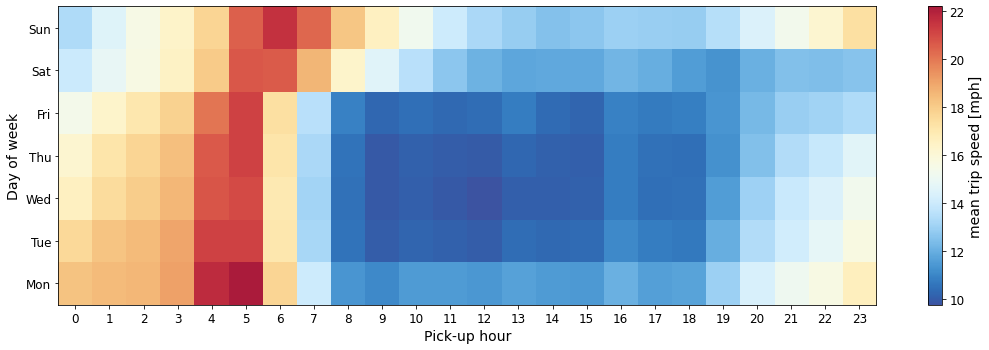

CPU times: user 4min 19s, sys: 12.3 s, total: 4min 31s
Wall time: 8min 35s


In [30]:
%%time
plt.figure(figsize=(15, 5))
df_filtered.plot('pickup_hour', 'pickup_day_of_week', what='mean(trip_speed_mph)', 
                 colorbar_label='mean trip speed [mph]', colorbar=True, colormap=cm_plusmin)
plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()

This make sense, this is like inverse of the duration plot above. So the results are consistent, adds confidence in our analysis.

Let's when we earn the most money. Let's find out when on average we would get the largest tip, and when we would make the most profit.

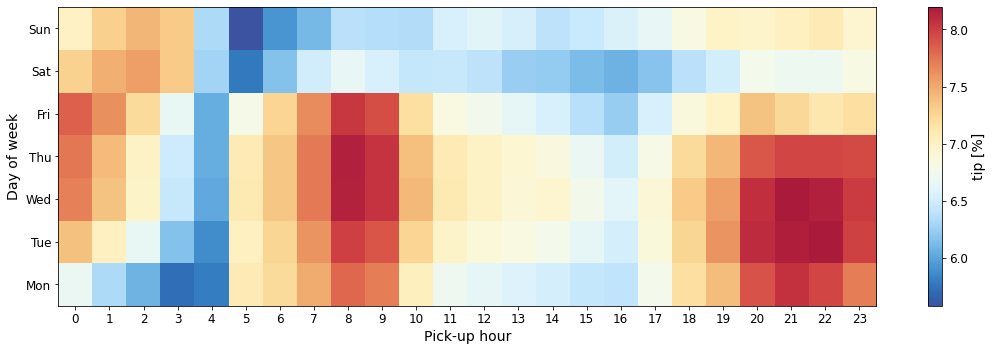

CPU times: user 4min 20s, sys: 8.35 s, total: 4min 28s
Wall time: 7min 58s


In [31]:
%%time
plt.figure(figsize=(15, 5))
df_filtered.plot('pickup_hour', 'pickup_day_of_week', what='mean(tip_percentage)',
                 colorbar_label='tip [%]', colorbar=True, colormap=cm_plusmin)
plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()

If we care about profit, simply looking at the fare amount is not optimal. Lets look at the fare divided by distance instead (to account for costs).

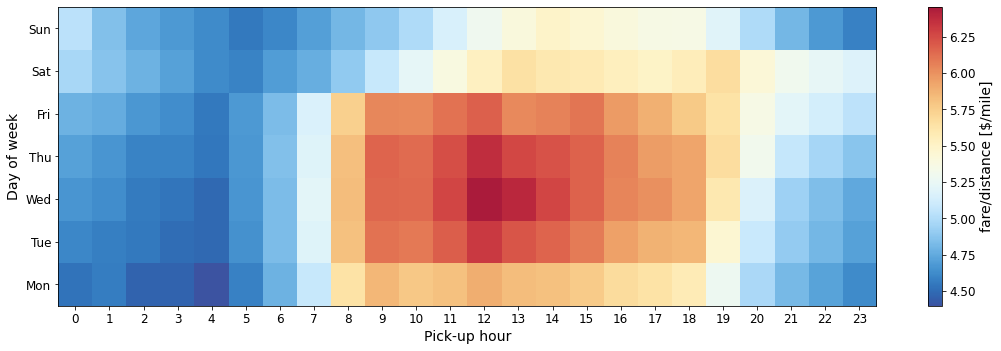

CPU times: user 4min 13s, sys: 10.1 s, total: 4min 23s
Wall time: 10min 13s


In [32]:
%%time
plt.figure(figsize=(15, 5))
df_filtered.plot('pickup_hour', 'pickup_day_of_week', what='mean(fare_over_distance)', 
                 colorbar_label='fare/distance [$/mile]', colorbar=True, colormap=cm_plusmin)
plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()

This makes sense: the best earnings per mile happen during rush hours, especually around noon. 

Notice the anti-pattern observed between the trip/distance and tip percentage plots. Optimal time for a taxi driver to be working is 8-10 in the morning: best pay, best tip, reasonable demand.

### Expensive computatons

Now let's look at the distance. The dataset provides the trip distance, i.e. the distance the taxi travelled from the pickup to the dropoff location. Given that we have the exact pickup and dropoff coordintes, we can calculate the "true" distance between the origin and the destination, as if we could fly directly between the two.

We call this *arc_distance* as it traces an arc on the surface of the Earth.

In [33]:
%%time
# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Expression to be executed with numpy - the default option
# df_filtered['arc_distance'] = arc_distance(df_filtered.pickup_longitude, 
#                                            df_filtered.pickup_latitude, 
#                                            df_filtered.dropoff_longitude, 
#                                            df_filtered.dropoff_latitude)

# Expression to be pre-compiled with numba, and then executed
df_filtered['arc_distance'] = arc_distance(df_filtered.pickup_longitude, 
                                           df_filtered.pickup_latitude, 
                                           df_filtered.dropoff_longitude, 
                                           df_filtered.dropoff_latitude).jit_numba()

# Expression to be pre-compiled with CUDA, and then executed on you GPU 
# provided you have a CUDA compatible NVIDIA GPU.
# df_filtered['arc_distance'] = arc_distance(df_filtered.pickup_longitude, 
#                                            df_filtered.pickup_latitude, 
#                                            df_filtered.dropoff_longitude, 
#                                            df_filtered.dropoff_latitude).jit_cuda()

CPU times: user 576 ms, sys: 48 ms, total: 624 ms
Wall time: 4.12 s


Now this is very computationally expensive feature to compute on the fly, even though all virtual expressions in Vaex and executed in parallel right out of the box. 

In such cases, Vaex provides easy ways to speed things up considerably. One way is to use numba (`jit_numba()`) or pythran (`jit_pythran()`) to pre-compile such expressions to C++ or Fortran respectively, the execution of which is much faster. You can even use CUDA(`jit_cuda()`) to utilise your NVIDIA graphics card if you have one at hand. 

Anyway, let's compare the distributions of actual vs "true" distances.

[########################################] 100.00% elapsed time  :   176.05s =  2.9m =  0.0h
[########################################] 100.00% elapsed time  :   770.11s =  12.8m =  0.2h
[----------------------------------------]  0.00% estimated time: unknown                 

/opt/conda/lib/python3.7/site-packages/vaex/viz/mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


[########################################] 100.00% elapsed time  :   837.96s =  14.0m =  0.2h
 

/opt/conda/lib/python3.7/site-packages/vaex/viz/mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


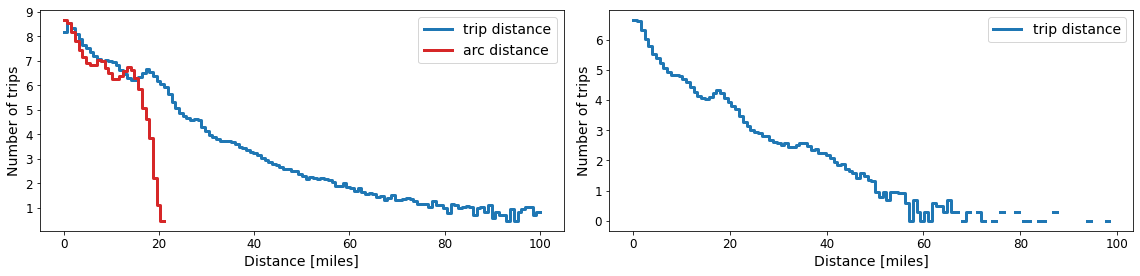

CPU times: user 5min 51s, sys: 38.2 s, total: 6min 29s
Wall time: 29min 44s


In [34]:
%%time
plt.figure(figsize=(16, 4))

plt.subplot(121)
df_filtered.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   label='trip distance', progress=True)
df_filtered.plot1d('arc_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C3', 
                   label='arc distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')


plt.subplot(122)
df_filtered.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   selection='arc_distance<0.06', label='trip distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')


plt.show()

It is interesting that the arc distance never exceeds 21 miles, but the distance the taxi travelled can be 5 times larger. In fact, there are millions of taxi trips for which the dropoff location is within 100 meters, or 0.06 miles, from the pickup location.

In [35]:
%%time
N_trips_small_arc_distance = len(df_filtered[df_filtered.arc_distance<0.06])
print(f'Number of trips with arc distance of less than 100 meters: {N_trips_small_arc_distance}')

<string>:1: RuntimeWarning: invalid value encountered in less


Number of trips with arc distance of less than 100 meters: 13607235
CPU times: user 2min 55s, sys: 8.93 s, total: 3min 4s
Wall time: 19min 25s


### YellowCabs through the years

Let us see how some key statistics have evolved throughout the years.

In [36]:
%%time
df_filtered['pickup_year'] = df_filtered.pickup_datetime.dt.year
df_groupby_year = df_filtered.groupby(by=df_filtered.pickup_year, 
                                      agg={'count': vaex.agg.count(),
                                           'trip_distance': vaex.agg.mean('trip_distance'),
                                           'arc_distance': vaex.agg.mean('arc_distance'),
                                           'tip_amount': vaex.agg.mean('tip_amount'),
                                           'tip_percentage': vaex.agg.mean('tip_percentage'),
                                           'fare_amount': vaex.agg.mean('fare_amount'),
                                           'total_amount': vaex.agg.mean('total_amount'),
                                           'passenger_count': vaex.agg.sum('passenger_count')})

CPU times: user 8min 11s, sys: 1min 52s, total: 10min 4s
Wall time: 43min 32s


Let's see the total number of taxi trips per year

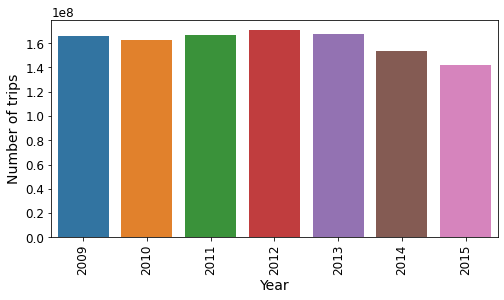

CPU times: user 188 ms, sys: 348 ms, total: 536 ms
Wall time: 903 ms


In [37]:
%%time
plt.figure(figsize=(8,4))
sns.barplot(x=df_groupby_year.pickup_year.values, y=df_groupby_year['count'].values)
plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.xticks(rotation='vertical')
plt.show()

Let's see how the trip fares and tips have evolved over the years

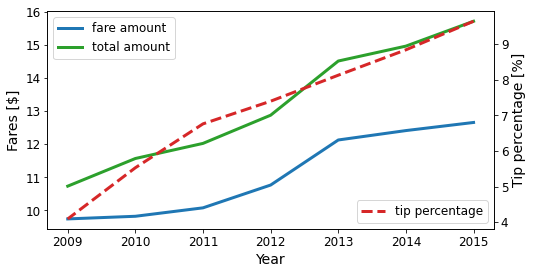

CPU times: user 304 ms, sys: 8 ms, total: 312 ms
Wall time: 307 ms


In [38]:
%%time
plt.figure(figsize=(8,4))
plt.plot(df_groupby_year.pickup_year.values, 
         df_groupby_year.fare_amount.values, 
         lw=3, color='C0', label='fare amount')
plt.plot(df_groupby_year.pickup_year.values, 
         df_groupby_year.total_amount.values, 
         lw=3, color='C2', label='total amount')
plt.xlabel('Year')
plt.ylabel('Fares [$]')
plt.legend()

plt.twinx()
plt.plot(df_groupby_year.pickup_year.values, 
         df_groupby_year.tip_percentage.values, 
         lw=3, ls='--', color='C3', label='tip percentage')

plt.legend(loc=4)
plt.ylabel('Tip percentage [%]')
plt.xticks(rotation='vertical')
plt.show()

Total number of passengers transported.

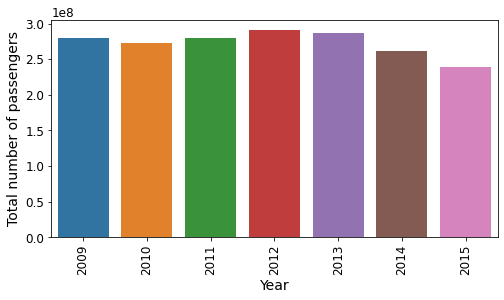

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 180 ms


In [39]:
%%time
plt.figure(figsize=(8,4))
sns.barplot(x=df_groupby_year.pickup_year.values, y=df_groupby_year.passenger_count.values)
plt.xlabel('Year')
plt.ylabel('Total number of passengers')
plt.xticks(rotation='vertical')
plt.show()

Mean trip and arc distance between the pickup and dropoff locations

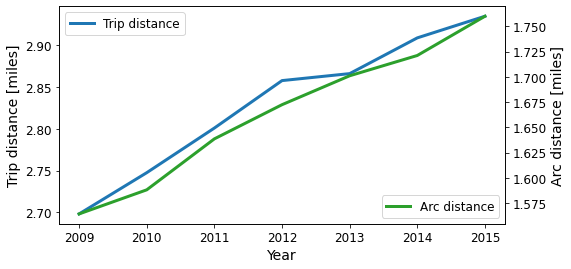

CPU times: user 344 ms, sys: 4 ms, total: 348 ms
Wall time: 377 ms


In [40]:
%%time
plt.figure(figsize=(8,4))
sns.lineplot(x=df_groupby_year.pickup_year.values, 
             y=df_groupby_year.trip_distance.values, 
             lw=3, color='C0', label='Trip distance')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Trip distance [miles]')

plt.twinx()
sns.lineplot(x=df_groupby_year.pickup_year.values, 
             y=df_groupby_year.arc_distance.values, 
             lw=3, color='C2', label='Arc distance')

plt.legend(loc=4)

plt.ylabel('Arc distance [miles]')
plt.xticks(rotation='vertical')
plt.show()

Interesting that even though the trend is very small, we observe an increase in both the arc and the trip distance as time goes on. This is especially interesting in light of increasing fares, and decreasing total number of trips as well as the total number of passengers taken.

### Payment methods

Finally, let's examine the way people way. First of all, let's check all of the options. 

In [41]:
%%time
# Inspect the payment_type
df_filtered.payment_type.str.lower().value_counts(progress=True)

[########################################] 100.00% elapsed time  :   604.87s =  10.1m =  0.2h
 CPU times: user 4min 21s, sys: 12.4 s, total: 4min 33s
Wall time: 10min 4s


csh          370685044
crd          364140209
cash         121798668
1             89357065
cas           55020668
2             52186175
credit        43296831
cre           29744372
unk             993923
noc             796745
no charge       384364
3               326293
dis             299200
no              147037
4               118303
dispute          71884
na               29539
5                   12
dtype: int64

[From the documentation provided](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):
- 1 = Credit card
- 2 = Cash
- 3 = No charge
- 4 = Dispute
- 5 = Unknown
- 6 = Voided trip

Given that there are only 6 valid options, we can simply map them to integers.

In [42]:
%%time
# Define a mapping dictionary
map_payment_type = {'csh': 2, 'crd': 1, 'cash': 2, '1': 1, 'cas': 2, '2': 2, 'credit': 1, 'cre': 1, 'unk': 5, 
                    'noc': 3, 'no charge': 3, '3':3, 'dis': 4, 'no ': 3, '4': 4, 'dispute': 4, 'na ': 5, '5':5}

df_filtered['payment_type_'] = df_filtered.payment_type.str.lower().map(map_payment_type, 
                                                                        default_value=-1, 
                                                                        allow_missing=True)

CPU times: user 6min 55s, sys: 10.6 s, total: 7min 5s
Wall time: 3min 45s


Now let's see how the payment habbits of passengeres evolved through the years

In [43]:
%%time
# Count the number of trips per year per payment type
df_groupby_year_payment_type = df_filtered.groupby(by=['pickup_year', 'payment_type_'], 
                                                   agg={'count': vaex.agg.count()})

# Map meaningful labels to the payment type codes
expr = df_groupby_year_payment_type.payment_type_.map(mapper={1: 'card', 
                                                              2: 'cash', 
                                                              3: 'No Charge', 
                                                              4: 'Dispute', 
                                                              5: 'Unknown'})
df_groupby_year_payment_type['payment_type_label'] = expr

CPU times: user 12min 13s, sys: 57.5 s, total: 13min 10s
Wall time: 25min 35s


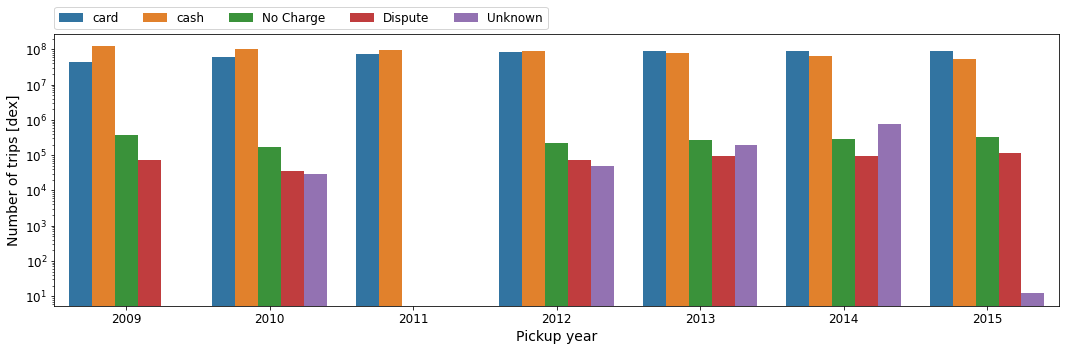

CPU times: user 908 ms, sys: 140 ms, total: 1.05 s
Wall time: 1.52 s


In [44]:
%%time
plt.figure(figsize=(18, 5))

sns.barplot(x='pickup_year', y='count', hue='payment_type_label', 
            data=df_groupby_year_payment_type.to_pandas_df(virtual=True))
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.00, 1.1), loc=2, borderaxespad=0., ncol=5)
plt.xlabel('Pickup year')
plt.ylabel('Number of trips [dex]')

plt.show()

Let's see how the habit of the passengers changes per day of week and time of week.

In [45]:
%%time
_filter = df_filtered.payment_type_<3
df_count_payment = df_filtered[_filter].groupby(by=['pickup_day_of_week', 'pickup_hour'], 
                                                agg={'card': vaex.agg.count(selection='payment_type_==1'),
                                                     'cash': vaex.agg.count(selection='payment_type_==2')
                                                    })

# Add the ratio between trips paid for by cash over those paid by card
df_count_payment['payment_ratio'] = df_count_payment.cash/df_count_payment.card

CPU times: user 21min 30s, sys: 43.5 s, total: 22min 14s
Wall time: 35min 38s


In [46]:
%%time
# Sort by pickup day of week and hour
df_count_payment_sorted = df_count_payment.sort(by=['pickup_day_of_week', 'pickup_hour'])

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 28.7 ms


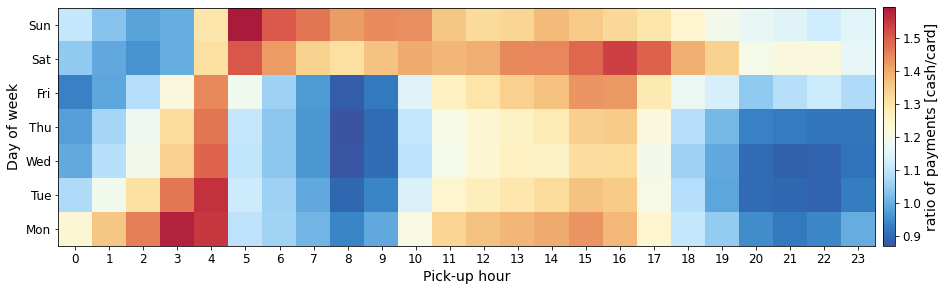

CPU times: user 592 ms, sys: 12 ms, total: 604 ms
Wall time: 694 ms


In [47]:
%%time
# Plot number of taxi trips per hours vs day of week
plt.figure(figsize=(15, 5))
plt.imshow(df_count_payment_sorted.payment_ratio.values.reshape(7, 24), origin='lower', cmap=cm_plusmin)
plt.colorbar(label='ratio of payments [cash/card]', fraction=0.0143, pad=0.01)

plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), label_day_list)
plt.xlabel('Pick-up hour')
plt.ylabel('Day of week')
plt.tick_params(labelsize=12)
plt.show()



It is interesting to notice the similar patterns as the tip percentages. Does this mean that passengers that pay by cash, on average don't tip as much as those that that pay by card? Let's look at the distributions.

[########################################] 100.00% elapsed time  :   897.91s =  15.0m =  0.2h
[########################################] 100.00% elapsed time  :   872.65s =  14.5m =  0.2h
 

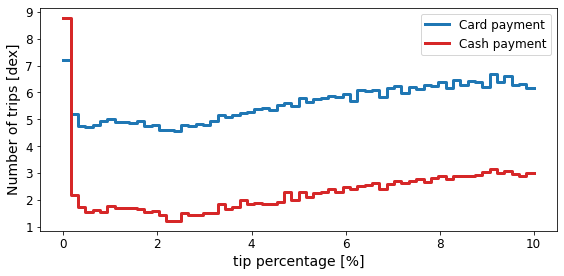

CPU times: user 9min 56s, sys: 19.7 s, total: 10min 16s
Wall time: 29min 31s


In [48]:
%%time
plt.figure(figsize=(8, 4))
f = 'log10'
shape = 64
limits = [0, 10]
df_filtered.plot1d('tip_percentage', limits=limits, shape=shape, 
                   selection='payment_type_ == 1', f=f,
                   progress=True, label='Card payment', color='C0', lw=3)
df_filtered.plot1d('tip_percentage', limits=limits, shape=shape, 
                   selection='payment_type_ == 2', f=f,
                   progress=True, label='Cash payment', color='C3', lw=3)

plt.legend()
plt.xlabel('tip percentage [%]')
plt.ylabel('Number of trips [dex]')

plt.show()

How often to passengers tip?

In [49]:
%%time
# for card payments
no_tips_card = (df_filtered.count(selection='(payment_type_ == 1) & (tip_amount == 0)') /  
                df_filtered.count(selection='payment_type_ == 1')) * 100.

print(f'{no_tips_card:.2f}% of the passengers that pay by card do not leave tips.')

3.00% of the passengers that pay by card do not leave tips.
CPU times: user 10min 33s, sys: 11.8 s, total: 10min 44s
Wall time: 18min 28s


In [50]:
%%time
# for cash payments
no_tips_cash = (df_filtered.count(selection='(payment_type_ == 2) & (tip_amount == 0)') /  
                df_filtered.count(selection='payment_type_ == 2')) * 100.

print(f'{no_tips_cash:.2f}% of the passengers that pay by card do not leave tips.')

99.97% of the passengers that pay by card do not leave tips.
CPU times: user 11min 14s, sys: 10.6 s, total: 11min 25s
Wall time: 16min 27s


So it looks like passengers that pay by cash either hardly ever leave a tip, which would be strange, or the tip is small and it is not recorded in the data.

But let's see the distributions of _fare_amount_ and _total_amount_, depending on whether the payment method was card or cash.

[########################################] 100.00% elapsed time  :   590.96s =  9.8m =  0.2h
[########################################] 100.00% elapsed time  :   589.68s =  9.8m =  0.2h
 

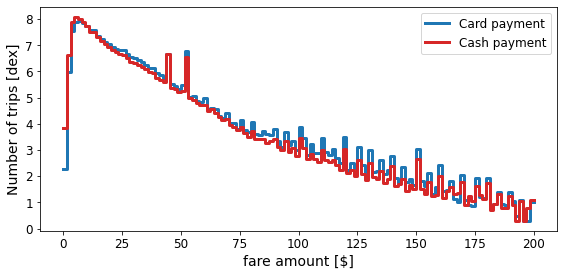

CPU times: user 10min 8s, sys: 14.4 s, total: 10min 23s
Wall time: 19min 41s


In [51]:
%%time
# Plot the distribution of fare amount, per payment method
plt.figure(figsize=(8, 4))
f = 'log10'
shape = 128
limits = [0, 200]
df_filtered.plot1d('fare_amount', limits=limits, shape=shape, 
                   selection='payment_type_ == 1', f=f,
                   progress=True, label='Card payment', color='C0', lw=3)
df_filtered.plot1d('fare_amount', limits=limits, shape=shape, 
                   selection='payment_type_ == 2', f=f,
                   progress=True, label='Cash payment', color='C3', lw=3)

plt.legend()
plt.xlabel('fare amount [$]')
plt.ylabel('Number of trips [dex]')

plt.show()

[########################################] 100.00% elapsed time  :   662.69s =  11.0m =  0.2h
[########################################] 100.00% elapsed time  :   645.50s =  10.8m =  0.2h
 

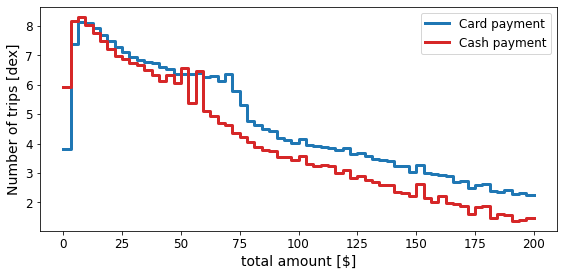

CPU times: user 10min 6s, sys: 15.4 s, total: 10min 21s
Wall time: 21min 48s


In [52]:
%%time
# Plot the distribution of total amount, per payment method
plt.figure(figsize=(8, 4))
f = 'log10'
shape = 64
limits = [0, 200]
df_filtered.plot1d('total_amount', limits=limits, shape=shape, 
                   selection='payment_type_ == 1', f=f,
                   progress=True, label='Card payment', color='C0', lw=3)
df_filtered.plot1d('total_amount', limits=limits, shape=shape, 
                   selection='payment_type_ == 2', f=f,
                   progress=True, label='Cash payment', color='C3', lw=3)

plt.legend()
plt.xlabel('total amount [$]')
plt.ylabel('Number of trips [dex]')

plt.show()

With such a big dataset, comprising over billion taxi trips done over 7 years, one can choose many possible way in which to slide and dice this dataset. I am sure it contains many valuable insights, suprises and secrets inside it. And with the power of Vaex, you can take your time and explore in the comfort of your own laptop.

# ノートブックの保存
すべてのセルを実行するようにして、放置してColabのセッションが切れるとしても、最終的に実行後のノートブックが確実に保存されるようにする。

In [53]:
%%time
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 25.8 ms
